In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
sam_mask = np.load('door_mask.npy')
print(sam_mask.shape)

boolean_mask = sam_mask[0]
boolean_mask.shape

(3, 1280, 720)


(1280, 720)

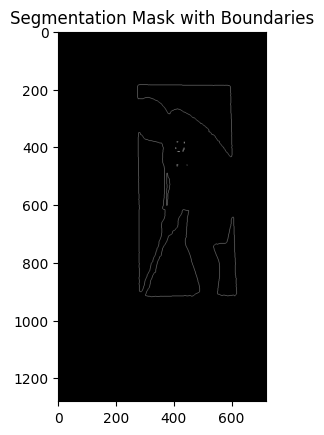

In [3]:
# Convert boolean mask to an 8-bit unsigned integer mask
int_mask = (boolean_mask * 255).astype(np.uint8)

# Convert the mask to a BGR image
bgr_mask = cv2.merge([int_mask, int_mask, int_mask])

# Convert the mask to grayscale
imgray = cv2.cvtColor(bgr_mask, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image
ret, thresh = cv2.threshold(imgray, 127, 255, 0)

# Find contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Create an empty image for drawing contours
tmp = np.zeros_like(bgr_mask)

# Draw the contours on the empty image
boundary = cv2.drawContours(tmp, contours, -1, (255, 255, 255), 1)

# Convert the boundary image to grayscale
boundary_gray = cv2.cvtColor(boundary, cv2.COLOR_BGR2GRAY)

# Set boundary pixels to 255
boundary_gray[boundary_gray > 0] = 255

# Visualize the boundary
plt.imshow(boundary_gray, cmap='gray')
plt.title('Segmentation Mask with Boundaries')
plt.show()

# Save the boundary image
plt.imsave("mask_boundary2.png", boundary_gray, cmap='gray')

In [4]:
boundary_gray.shape

(1280, 720)

In [5]:
# [{'x': 240, 'y': 160, 'width': 414, 'height': 784, 'label': ''}]

# Example top left corner and crop size
top_left_x = 240 # X coordinate of the top left corner
top_left_y = 160  # Y coordinate of the top left corner
crop_width = 414  # Width of the crop region
crop_height = 784  # Height of the crop region

# Perform the cropping operation
cropped_image = boundary_gray[top_left_y:top_left_y + crop_height, top_left_x:top_left_x + crop_width]

# Display the cropped image shape
print("Cropped image shape:", cropped_image.shape)

Cropped image shape: (784, 414)


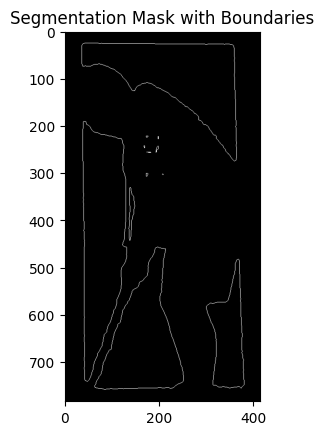

In [6]:
# Visualize the boundary
plt.imshow(cropped_image, cmap='gray')
plt.title('Segmentation Mask with Boundaries')
plt.show()

# Save the boundary image
plt.imsave("cropped_image.png", cropped_image, cmap='gray')

In [8]:
cropped_image.shape, cropped_image.dtype

((784, 414), dtype('uint8'))

In [12]:
len(contours), len(boundary)

(12, 1280)

## Find minimum bounding Rectangle/Polygon

In [13]:
# Step 1: Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ensure there is at least one contour found
if len(contours) == 0:
    raise ValueError("No contours found in the mask.")

In [14]:
len(contours)

12

In [15]:
# Step 2: Calculate the minimum area bounding rectangle
min_area_rect = cv2.minAreaRect(contours[0])

In [16]:
min_area_rect

((576.5943603515625, 780.867431640625),
 (273.0493469238281, 74.30321502685547),
 87.54597473144531)

In [18]:
# Step 3: Get the four vertices of the rectangle
box_points = cv2.boxPoints(min_area_rect)
box_points = np.intp(box_points)  # Convert to integer
box_points

array([[533, 646],
       [607, 642],
       [619, 915],
       [545, 918]])

In [19]:
# To draw the bounding box on the mask (for visualization)
bounding_box = cv2.drawContours(thresh.copy(), [box_points], 0, (255, 255, 255), 2)

# Output the results
print(f"Minimum Area Bounding Rectangle (center, size, angle): {min_area_rect}")
print(f"Bounding Box Vertices: {box_points}")

Minimum Area Bounding Rectangle (center, size, angle): ((576.5943603515625, 780.867431640625), (273.0493469238281, 74.30321502685547), 87.54597473144531)
Bounding Box Vertices: [[533 646]
 [607 642]
 [619 915]
 [545 918]]


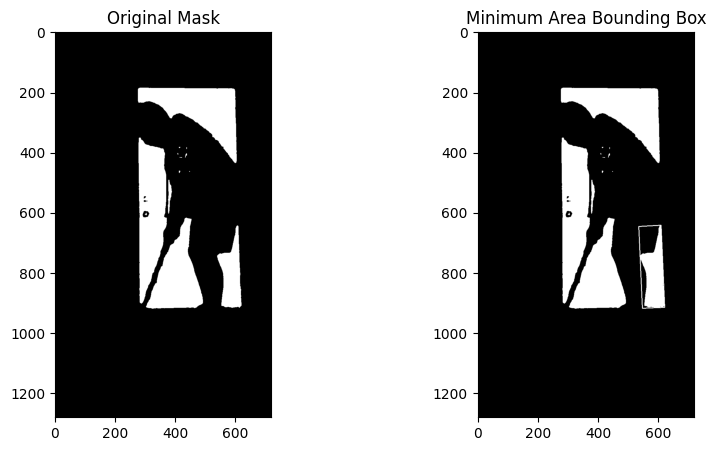

In [20]:
# Optional: visualize the mask and bounding box
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Mask")
plt.imshow(thresh, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Minimum Area Bounding Box")
plt.imshow(bounding_box, cmap='gray')

plt.show()

## Draw all contours using cv2 minarearect method

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

count = 0
for contour in contours:
    # calculate mini area rectangle 
    min_area_rect = cv2.minAreaRect(contour)

    # calculate 4 vertices of the bounding rectangle
    box_points = cv2.boxPoints(min_area_rect)
    box_points = np.intp(box_points)  # Convert to integer

    # get bounding box image
    bounding_box = cv2.drawContours(cv2.cvtColor(thresh.copy(), cv2.COLOR_GRAY2BGR), [box_points], 0, (0, 255, 0), 2)  # Color set to green (BGR format)

    # plot and save the image
    plt.imsave(f"contours/contour_{count}.png", bounding_box)

    count += 1


## Draw all contours using cv2.boundingrect method

In [35]:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ensure there is at least one contour found
if len(contours) == 0:
    raise ValueError("No contours found in the mask.")


In [36]:
count = 0
for contour in contours:
    # Step 4: Calculate the bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)

    # To draw the bounding rectangle on the mask (for visualization)
    bounding_rect = cv2.rectangle(cv2.cvtColor(thresh.copy(), cv2.COLOR_GRAY2BGR), (x, y), (x+w, y+h), (0, 255, 0), 2)

    plt.imsave(f"contours1/contour_{count}.png", bounding_rect)

    count += 1

## combine the bounding rectangles into one single rectangle 

Combined Bounding Rectangle: x=275, y=185, width=344, height=735


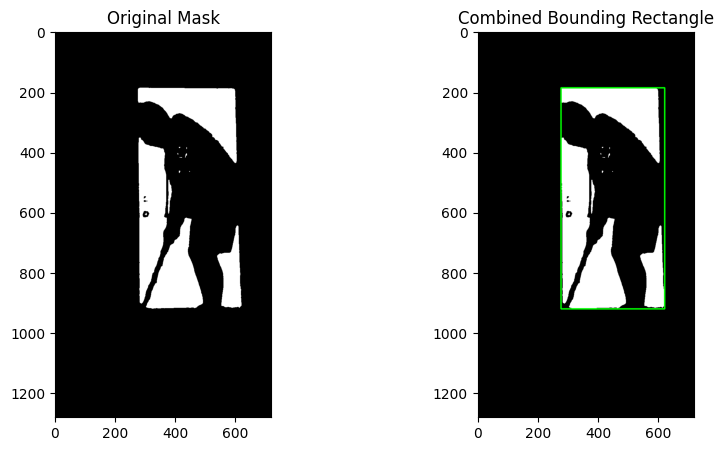

In [39]:
# Step 2: Calculate the bounding rectangles for each contour
bounding_rects = [cv2.boundingRect(contour) for contour in contours]

# Step 3: Combine these rectangles
# Initialize the combined bounding rectangle with the first bounding rectangle
x_min, y_min, x_max, y_max = float('inf'), float('inf'), float('-inf'), float('-inf')

for x, y, w, h in bounding_rects:
    x_min = min(x_min, x)
    y_min = min(y_min, y)
    x_max = max(x_max, x + w)
    y_max = max(y_max, y + h)

# The combined bounding rectangle
combined_bounding_rect = (x_min, y_min, x_max - x_min, y_max - y_min)

# Draw the combined bounding rectangle on the mask (for visualization)
combined_rect_img = cv2.rectangle(cv2.cvtColor(thresh.copy(), cv2.COLOR_GRAY2BGR), (x_min, y_min), (x_max, y_max), (0, 255, 0), 4)

# Output the results
print(f"Combined Bounding Rectangle: x={x_min}, y={y_min}, width={x_max - x_min}, height={y_max - y_min}")


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Mask")
plt.imshow(thresh, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Combined Bounding Rectangle")
plt.imshow(combined_rect_img)

plt.show()

In [40]:
plt.imsave(f"contours1/combined_contours.png", combined_rect_img)

## Combine contours for cv2.minarearect method

In [43]:
# Step 2: Calculate the bounding rectangles for each contour
min_area_rects = [cv2.minAreaRect(contour) for contour in contours]
box_points = [np.intp(cv2.boxPoints(min_area_rect)) for min_area_rect in min_area_rects]

Combined Bounding Rectangle: x=275, y=184, width=344, height=731


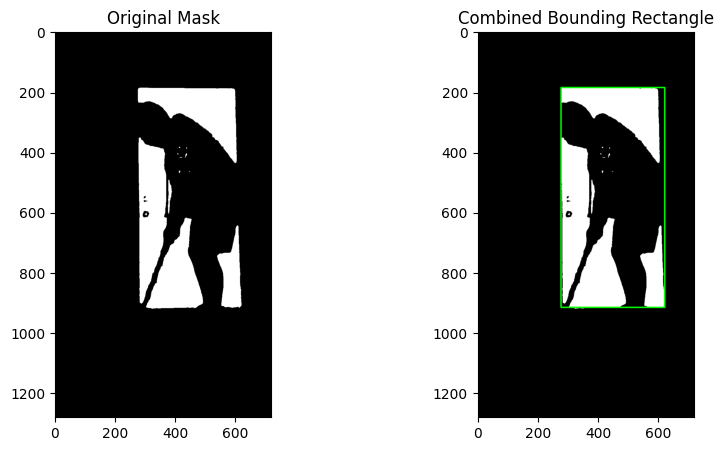

In [61]:
# Step 3: Combine these rectangles
# Initialize the combined bounding rectangle with the first bounding rectangle
x_min, y_min, x_max, y_max = float('inf'), float('inf'), float('-inf'), float('-inf')

for box_point in box_points:
    x_min = min(x_min, box_point[1][0])
    y_min = min(y_min, box_point[1][1])
    x_max = max(x_max, box_point[2][0])
    y_max = max(y_max, box_point[2][1])

# The combined bounding rectangle
combined_bounding_rect = (x_min, y_min, x_max - x_min, y_max - y_min)

# Draw the combined bounding rectangle on the mask (for visualization)
combined_rect_img = cv2.rectangle(cv2.cvtColor(thresh.copy(), cv2.COLOR_GRAY2BGR), (x_min, y_min), (x_max, y_max), (0, 255, 0), 4)

# Output the results
print(f"Combined Bounding Rectangle: x={x_min}, y={y_min}, width={x_max - x_min}, height={y_max - y_min}")


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Mask")
plt.imshow(thresh, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Combined Bounding Rectangle")
plt.imshow(combined_rect_img)

plt.show()

In [57]:
len(box_points)

12

## Another approach:
This is the approach that worked best so far

/tmp/ipykernel_505127/1850904240.py:25: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  combined_box_points = np.int0(combined_box_points)  # Convert to integer


Combined Minimum Area Bounding Rectangle: ((444.95648193359375, 578.3007202148438), (792.184326171875, 339.14044189453125), 89.14885711669922)
Combined Bounding Box Vertices: [[269 184]
 [608 179]
 [620 971]
 [281 976]]


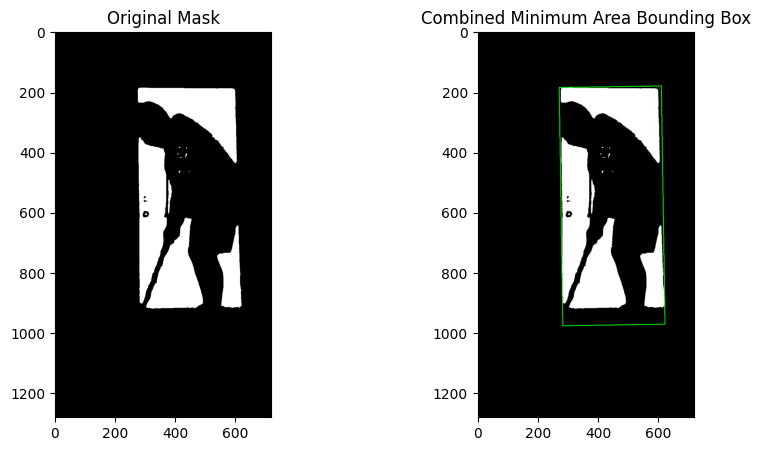

In [62]:

# Step 1: Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ensure there are contours found
if len(contours) == 0:
    raise ValueError("No contours found in the mask.")

# Step 2: Calculate the minimum area bounding rectangles for each contour
min_area_rects = [cv2.minAreaRect(contour) for contour in contours]

# Combine the points of all the rectangles
all_box_points = []

for rect in min_area_rects:
    box = cv2.boxPoints(rect)  # Get the 4 points of the rectangle
    all_box_points.extend(box)

all_box_points = np.array(all_box_points)

# Step 3: Find the overall minimum area bounding rectangle
combined_min_area_rect = cv2.minAreaRect(all_box_points)

# Get the four vertices of the combined rectangle
combined_box_points = cv2.boxPoints(combined_min_area_rect)
combined_box_points = np.int0(combined_box_points)  # Convert to integer

# To draw the combined bounding box on the mask (for visualization)
combined_rect_img = cv2.drawContours(cv2.cvtColor(thresh.copy(), cv2.COLOR_GRAY2BGR), [combined_box_points], 0, (0, 255, 0), 2)

# Output the results
print(f"Combined Minimum Area Bounding Rectangle: {combined_min_area_rect}")
print(f"Combined Bounding Box Vertices: {combined_box_points}")


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Mask")
plt.imshow(thresh, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Combined Minimum Area Bounding Box")
plt.imshow(combined_rect_img)

plt.show()


In [63]:
plt.imsave("combined_contours.png", combined_rect_img)

In [64]:
import math 

sorted_points = combined_box_points[np.argsort(combined_box_points[:, 1])]
sorted_points = sorted_points[np.argsort(sorted_points[:, 0])]

# Identify the top-right and bottom-right vertices
# top-right: the point with maximum x-coordinate from the top two points
# bottom-right: the point with maximum x-coordinate from the bottom two points
top_two = sorted_points[:2]
bottom_two = sorted_points[2:]

top_right = top_two[np.argmax(top_two[:, 0])]
bottom_right = bottom_two[np.argmax(bottom_two[:, 0])]

# Calculate the differences in coordinates
dy = bottom_right[1] - top_right[1]
dx = bottom_right[0] - top_right[0]

# Calculate the angle in radians
angle_radians = math.atan2(dy, dx)

# Convert the angle to degrees
angle_degrees = math.degrees(angle_radians)

# Since we need the angle with the vertical edge (y-axis), we take 90 degrees minus the calculated angle
angle_with_vertical = 90 - angle_degrees

print(f"Angle of the right vertical edge with the right edge of the image: {angle_with_vertical:.2f} degrees")

Angle of the right vertical edge with the right edge of the image: 90.85 degrees


In [65]:
angle_degrees

-0.8450092232020165